# Loading modules

In [66]:
import csv

import numpy as np
import pandas as pd
import statsmodels.api as sm

from numpy import trapz
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import simpson
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

plt.rcParams['text.usetex'] = True

# Loading the data 

In [213]:
# Setting datapaths... 
dataPath = "/Users/duuta/inclusiveEnergy-/LabFit/training_data_dc.csv"
dataTestingmac ="/Users/duuta/inclusiveEnergy-/LabFit/240902-MPX10DP10mmdatacollection-MPX-1.csv"
dataTestMAC = "/Users/duuta/inclusiveEnergy-/LabFit/test_MAC.csv"
dataTestE6P = "/Users/duuta/inclusiveEnergy-/LabFit/test_E6P.csv"


# loading data... 
data = pd.read_csv(dataPath)
test_mac = pd.read_csv(dataTesting)
test_MAC = pd.read_csv(dataTestMAC)
test_E6P = pd.read_csv(dataTestE6P)

# rename specific cols 
data.rename(columns={"LPM Rota":"LPM_Rota", 'cd':'dcoef'}, inplace=True)

# rename cols, test data
test_MAC.rename(columns={"LPM Rota":"LPM_Rota", 'cd':'dcoef'}, inplace=True)
test_mac.rename(columns={"LPM Rota":"LPM_Rota", 'cd':'dcoef'}, inplace=True)
test_E6P.rename(columns={"LPM Rota":"LPM_Rota", 'cd':'dcoef'}, inplace=True)

# drop colums, train data
data0=data.drop(columns={'periph_ch1', 'periph_ch1_lpm',})
print(data0.columns)
		
# labFit CONSTANTs
A=0.21334
B=0.14933
C=0.033616
D=0.023546

# standard constants
output_lpm=100000  # atm pressure in Pa
Tsb=30.66         # 
KCorrection=273.15          # Kelvin temp correction 
Tn=293.15  # some constant, not sure what exactly it is... some kind of temperature in degrees (20), then Kelvin corrected
A1=0.0005366622509
A2=0.0002010619298
r0=1.184


# epsilon
epsilon=1e-1

Index(['Static Pressure', 'LPM_Rota', 'temp_mcu', 'Static_Pa', 'SP_mV',
       'DP_mV', 'Differential_Pa', 'Flow_lph', 'SB lpm', 'Accuracy', 'Error',
       'ideal flow', 'dcoef'],
      dtype='object')


In [68]:
# write csv module function to eliminate duplicates
# use pandas `duplicated` for current tasks

In [69]:
duplicate_mask = data0.duplicated(keep='first')

In [70]:
np.nonzero(duplicate_mask.values)

(array([ 14,  17,  37,  38,  67,  73,  89,  95,  98, 101, 106, 107, 116,
        119, 136, 137, 139, 157, 158, 167, 179, 190, 191, 194, 196, 200,
        209, 211, 214, 218, 221, 224, 230, 233, 239, 245]),)

In [71]:
range(len(data0.loc[np.nonzero(duplicate_mask.values)[0]]))

range(0, 36)

In [72]:
# render the duplicates for the two variables of interest... 
# and make a scatter of the variables 
# also I could show the duplicates in excel
# 

In [73]:
(data0[data0.duplicated(keep=False)]).columns

Index(['Static Pressure', 'LPM_Rota', 'temp_mcu', 'Static_Pa', 'SP_mV',
       'DP_mV', 'Differential_Pa', 'Flow_lph', 'SB lpm', 'Accuracy', 'Error',
       'ideal flow', 'dcoef'],
      dtype='object')

In [74]:
df = data0[data0.duplicated(keep=False)]
df0 = df.groupby(df.columns.tolist()).apply(lambda x: tuple(x.index)).reset_index(name='idx')
df00 = df.groupby(df.columns.tolist()).apply(lambda x: tuple(x.index)).tolist()
print(df00)

[(97, 98), (135, 136, 137), (13, 14), (208, 209), (66, 67), (229, 230), (189, 190, 191), (219, 221), (199, 200), (100, 101), (36, 37, 38), (88, 89), (117, 119), (138, 139), (16, 17), (238, 239), (210, 211), (232, 233), (193, 194), (156, 157, 158), (223, 224), (166, 167), (213, 214), (72, 73), (243, 245), (177, 179), (94, 95), (216, 218), (115, 116), (105, 106, 107), (195, 196)]


# Meta-functions for computations 

In [75]:
# NB choice of best model is not based on accuracy is also based on functional form and possible runins resulting from 
# bad functional form 
# X1 : 'Static_Pa'  X2: 'Differential_Pa'
#data['labfit'] = data.apply(labfit_model, axis=1)
#data['labfit0'] = data.apply(lambda row: labfit_function(row), axis=1)
# labfit_best1 : Y=A/X2+B*EXP(C*X1)+D/X2**2 
# labfit_best0 : Y=A*X1**(B*X2**C)+D/X2

# Reduced Chi_squared 
R00 = 0.136442E-01
R01 = 0.967780E-02

labfit1 = lambda row: A*row.Differential_Pa + B*np.exp(C*row.Static_Pa) + D/row.Differential_Pa**2 
labfit0 = lambda row: A*row.Differential_Pa**(B*row.Static_Pa**C) + D/row.Static_Pa


labfit1_scaled = lambda row: A*row.DP_scale + B*np.exp(C*row.SP_scale) + D/(row.DP_scale**2 + epsilon)
labfit0_scaled = lambda row: A*row.DP_scale**(B*row.SP_scale**C) + D/(row.SP_scale + epsilon)


LPM_rota_normalization = lambda row: row.LPM_Rota *(row.Static_Pa + output_lpm) / (output_lpm*(Tn/(row.temp_mcu + KCorrection)))
SB_lpm = lambda row: row.Flow_lph/60 


def flow_amounts(dcoeff, Differential_Pa):
    return dcoeff*A2*np.sqrt(2*Differential_Pa)/(r0*(A2/A1)**2)

# Computing desired variables to from system

In [76]:
# unscaled 
data0['labfit_dcoef0'] = data0.apply(labfit0, axis=1)
data0['labfit_dcoef1'] = data0.apply(labfit1, axis=1)


#  some transformations a
data0['LPM_rota_norm'] = data0.apply(LPM_rota_normalization, axis=1)
data0['SB_lpm'] = data0.apply(SB_lpm, axis=1)
data0['dcoef0'] = data0['LPM_rota_norm']/data0['SB_lpm']


# Min-Max scaling  
data0['SP_scale'] =  (data0.Static_Pa - min(data0.Static_Pa))/ (max(data0.Static_Pa) - min(data0.Static_Pa) ) 
data0['DP_scale'] =  (data0.Differential_Pa - min(data0.Differential_Pa))/ (max(data0.Differential_Pa) - min(data0.Differential_Pa)) 


# scaled results
data0['dc_lfs0'] = data0.apply(labfit0_scaled, axis=1)
data0['dc_lfs1'] = data0.apply(labfit1_scaled, axis=1)


# map high values in exponential fit to 0
data0['labfit_dcoef1_mapp']= data0['labfit_dcoef1'].map({np.inf: 0})

/var/folders/f4/q6n418p95nb77wmf4l9zydddrkwtmh/T/ipykernel_2895/1728418169.py:13: RuntimeWarning: overflow encountered in exp
  labfit1 = lambda row: A*row.Differential_Pa + B*np.exp(C*row.Static_Pa) + D/row.Differential_Pa**2


In [77]:
data0.drop_duplicates(inplace=True) 

In [78]:
# check correlation of features

feature_correlation = np.corrcoef(data0['SP_scale'], data0['DP_scale'])[1, 0]


In [79]:
SPcorr = np.corrcoef(data0['SP_scale'], data0['dcoef0'])[0,1]
DPcorr = np.corrcoef(data0['DP_scale'], data0['dcoef0'])[0, 1]

In [80]:
corr = data0.corr()

/var/folders/f4/q6n418p95nb77wmf4l9zydddrkwtmh/T/ipykernel_2895/3798843167.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data0.corr()


In [81]:
corr.style.background_gradient(cmap='coolwarm')

/Users/duuta/anaconda3/envs/torchpp/lib/python3.10/site-packages/pandas/io/formats/style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/Users/duuta/anaconda3/envs/torchpp/lib/python3.10/site-packages/pandas/io/formats/style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,Static Pressure,LPM_Rota,temp_mcu,Static_Pa,SP_mV,DP_mV,Differential_Pa,Flow_lph,SB lpm,Accuracy,ideal flow,dcoef,labfit_dcoef0,labfit_dcoef1,LPM_rota_norm,SB_lpm,dcoef0,SP_scale,DP_scale,dc_lfs0,dc_lfs1,labfit_dcoef1_mapp
Static Pressure,1.000000,-0.044300,0.038305,0.999480,0.999480,0.037751,-0.038589,-0.037937,-0.037937,0.119742,-0.037955,0.375486,0.002107,0.000000,0.071408,-0.037937,0.589951,0.999480,-0.038589,-0.601051,0.129657,nan
LPM_Rota,-0.044300,1.000000,0.133293,-0.045175,-0.045170,-0.999383,0.977149,0.999399,0.999399,-0.567187,0.999398,-0.512173,0.973090,-0.000000,0.986795,0.999399,0.477769,-0.045175,0.977149,0.663834,-0.762338,nan
temp_mcu,0.038305,0.133293,1.000000,0.035921,0.035925,-0.125571,0.166654,0.125657,0.125657,-0.175992,0.125600,0.032802,0.096869,-0.000000,0.150432,0.125657,0.203166,0.035921,0.166654,0.055548,0.044430,nan
Static_Pa,0.999480,-0.045175,0.035921,1.000000,1.000000,0.038554,-0.038531,-0.038747,-0.038747,0.123501,-0.038767,0.380027,0.000713,0.000000,0.070488,-0.038747,0.587676,1.000000,-0.038531,-0.605041,0.133680,nan
SP_mV,0.999480,-0.045170,0.035925,1.000000,1.000000,0.038548,-0.038532,-0.038742,-0.038742,0.123487,-0.038762,0.380007,0.000723,0.000000,0.070492,-0.038742,0.587684,1.000000,-0.038532,-0.605034,0.133672,nan
DP_mV,0.037751,-0.999383,-0.125571,0.038554,0.038548,1.000000,-0.972546,-0.999998,-0.999998,0.563511,-0.999998,0.521498,-0.978428,0.000000,-0.986927,-0.999998,-0.477337,0.038554,-0.972546,-0.664450,0.765186,nan
Differential_Pa,-0.038589,0.977149,0.166654,-0.038531,-0.038532,-0.972546,1.000000,0.972586,0.972586,-0.489158,0.972572,-0.426061,0.910087,-0.000000,0.966521,0.972586,0.427278,-0.038531,1.000000,0.606042,-0.676654,nan
Flow_lph,-0.037937,0.999399,0.125657,-0.038747,-0.038742,-0.999998,0.972586,1.000000,1.000000,-0.563790,1.000000,-0.521374,0.978382,-0.000000,0.986931,1.000000,0.477473,-0.038747,0.972586,0.664466,-0.765200,nan
SB lpm,-0.037937,0.999399,0.125657,-0.038747,-0.038742,-0.999998,0.972586,1.000000,1.000000,-0.563790,1.000000,-0.521374,0.978382,-0.000000,0.986931,1.000000,0.477473,-0.038747,0.972586,0.664466,-0.765200,nan
Accuracy,0.119742,-0.567187,-0.175992,0.123501,0.123487,0.563511,-0.489158,-0.563790,-0.563790,1.000000,-0.563799,0.424806,-0.613621,0.000000,-0.556742,-0.563790,-0.711340,0.123501,-0.489158,-0.459487,0.428068,nan


# Columns or variables 

In [82]:
data0.columns

Index(['Static Pressure', 'LPM_Rota', 'temp_mcu', 'Static_Pa', 'SP_mV',
       'DP_mV', 'Differential_Pa', 'Flow_lph', 'SB lpm', 'Accuracy', 'Error',
       'ideal flow', 'dcoef', 'labfit_dcoef0', 'labfit_dcoef1',
       'LPM_rota_norm', 'SB_lpm', 'dcoef0', 'SP_scale', 'DP_scale', 'dc_lfs0',
       'dc_lfs1', 'labfit_dcoef1_mapp'],
      dtype='object')

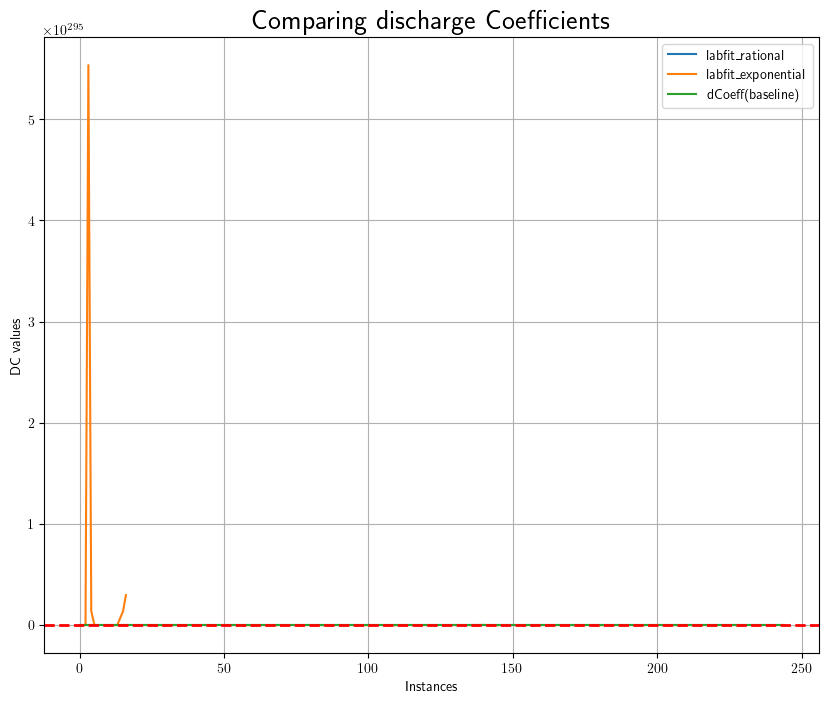

In [83]:
plt.figure(figsize=(10, 8))
plt.plot(data0['labfit_dcoef0'], label='labfit_rational')
plt.plot(data0['labfit_dcoef1'], label='labfit_exponential')
plt.plot(data0['dcoef0'], label='dCoeff(baseline)')
plt.axhline(y=1, linestyle='--', color='red', linewidth=2.0)
plt.title('Comparing discharge Coefficients', fontsize=20)
plt.xlabel('Instances', fontsize=10)
plt.ylabel('DC values', fontsize=10)
plt.grid(True)
plt.legend()
#plt.plot(data['labfit0']/data['Static_Pa'])

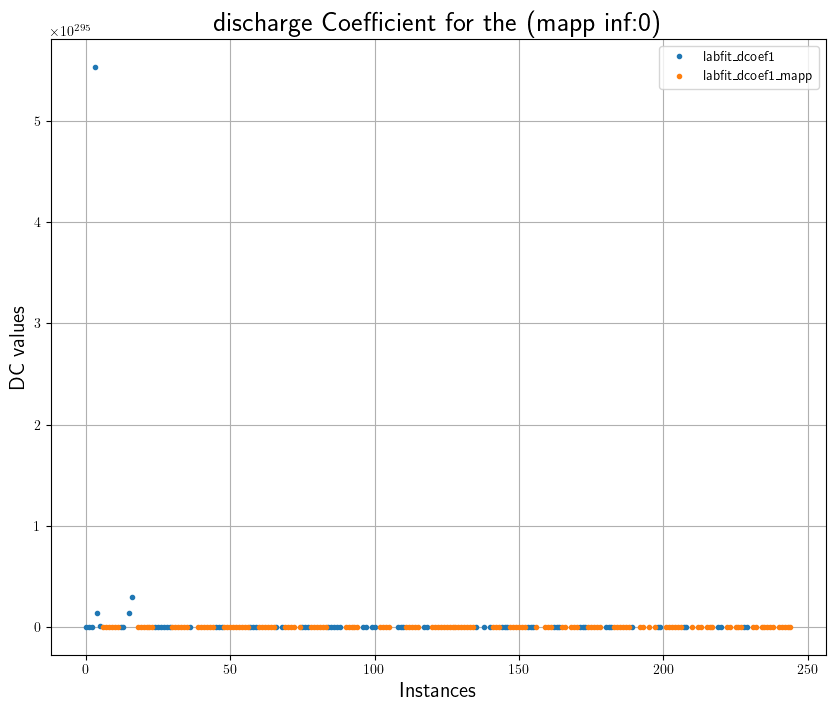

In [84]:
plt.figure(figsize=(10, 8))
plt.plot(data0['labfit_dcoef1'], '.', label='labfit_dcoef1')
plt.plot(data0['labfit_dcoef1_mapp'], '.', label='labfit_dcoef1_mapp')
#plt.axhline(y=1, linestyle='--', color='red', linewidth=2.0)
plt.title('discharge Coefficient for the (mapp inf:0)', fontsize=20)
plt.xlabel('Instances', fontsize=15)
plt.ylabel('DC values', fontsize=15)
plt.grid(True)
plt.legend()


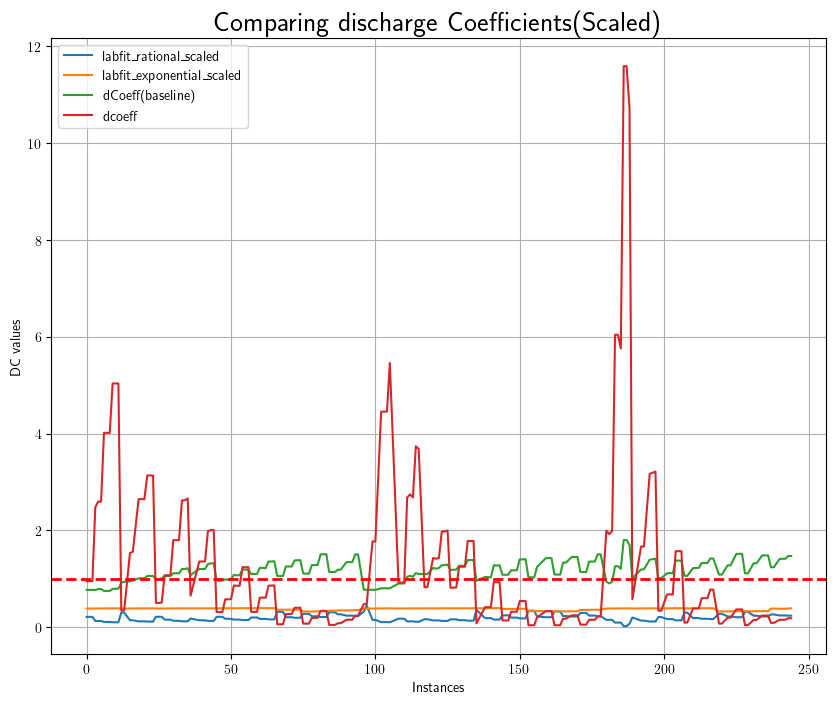

In [85]:
data0['dc_lfs0'] = data0.apply(labfit0_scaled, axis=1)
data0['dc_lfs1'] = data0.apply(labfit1_scaled, axis=1)



plt.figure(figsize=(10, 8))
plt.plot(data0['dc_lfs0'], label='labfit_rational_scaled')
plt.plot(data0['dc_lfs1'], label='labfit_exponential_scaled')
plt.plot(data0['dcoef0'], label='dCoeff(baseline)')
plt.plot(data0['dcoef'], label='dcoeff')
plt.axhline(y=1, linestyle='--', color='red', linewidth=2.0)
plt.title('Comparing discharge Coefficients(Scaled)', fontsize=20)
plt.xlabel('Instances', fontsize=10)
plt.ylabel('DC values', fontsize=10)
plt.grid(True)
plt.legend()


# scaled versions of the fits are much stable, could use the exponential for example
# the exponential is the best of them, the labfit is pretty impressive, there  its still some 
# deviations from ideal but the best so far, 30 
# what are the benefits to the business to choose the exponential model, with some scaling if that's possible?
# or an adjusted exponential, where we add a constant term to prevent in stability? 
# 

In [86]:
np.isnan(data0['labfit_dcoef1_mapp']
).count()

210

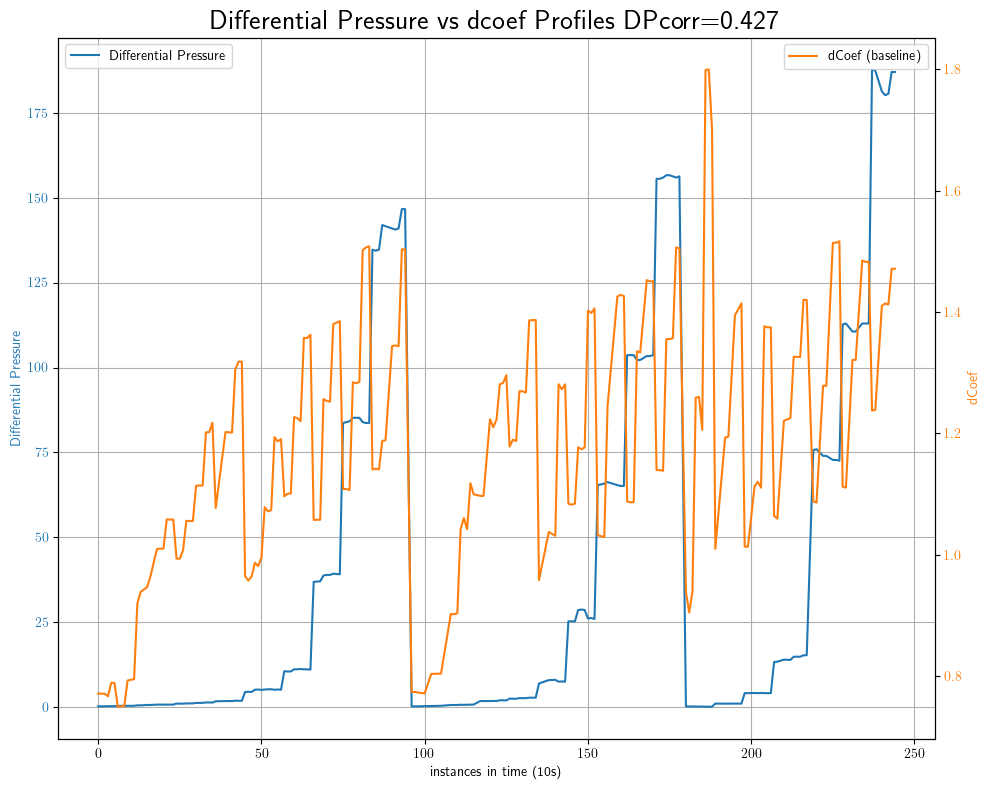

In [174]:
# I want to see the dcoef against the pressure/statics and differential 

#plt.plot(data0['Static_Pa'], label='Static Pressure')
#plt.plot(data0['dcoef0'], label='dCoef (baseline)')


fig, ax1 = plt.subplots(figsize=(10, 8))

color = 'tab:blue'
ax1.set_xlabel('instances in time (10s)', fontsize=10)
ax1.set_ylabel('Differential Pressure', color=color, fontsize=10)
ax1.plot(data0['Differential_Pa'], label='Differential Pressure', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc=2)
ax1.grid()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('dCoef', color=color, fontsize=10)  # we already handled the x-label with ax1
ax2.plot(data0['dcoef0'], label='dCoef (baseline)', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc=0)
plt.title(f'Differential Pressure vs dcoef Profiles {DPcorr=:.3f}', fontsize=20)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [ ]:
# mark peaks 
# 

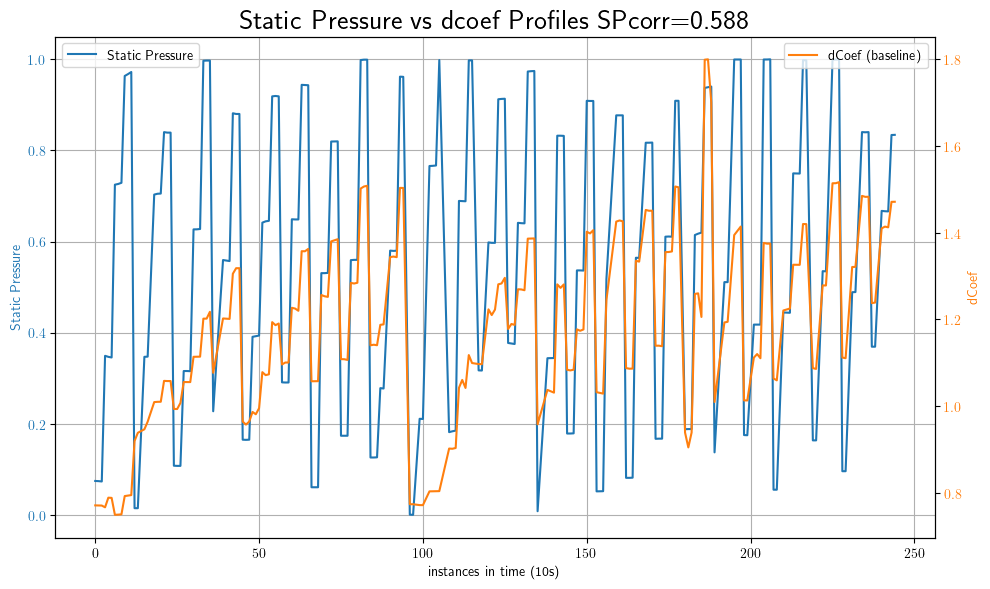

In [166]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('instances in time (10s)', fontsize=10)
ax1.set_ylabel('Static Pressure', color=color, fontsize=10)
ax1.plot(data0['SP_scale'], label='Static Pressure', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()
ax1.legend()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('dCoef', color=color, fontsize=10)  # we already handled the x-label with ax1
ax2.plot(data0['dcoef0'], label='dCoef (baseline)', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend()

plt.title(f"Static Pressure vs dcoef Profiles {SPcorr=:.3f}", fontsize=20)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


# building a model... 

In [91]:
# where is the static pressure reading from?
# the baseline dCoeff closely follows the static pressure...
# its more sensitive to the static pressure than differential pressure 
# the flow meters are more sensitive to static pressure than to differential pressure
# is this surprising? (we do some conversions of the readings from the meter before the computations)
# in the excel is says new cd (static pressure)
# why does static pressure fluctuate a lot? 
# it is unlikely its manually controlled ( given the resolution of the fluctuations)? 
# why use the static pressure and differential pressure (these are the raw values from the meter)


In [92]:
# structuring a model 
# static pressure, differential pressure, decof0
# surrogate data 
x0=np.random.rand(100,).reshape(-1, 1)
x1=np.random.rand(100,).reshape(-1, 1)
y = x0 + x1 
X=np.hstack((x0, x1))

In [93]:
linreg_surrogate = LinearRegression().fit(X, y)

In [94]:
R_sq=linreg_surrogate.score(X, y)

In [95]:
linreg_surrogate.coef_

array([[1., 1.]])

In [96]:
y_pred=linreg_surrogate.predict(X)

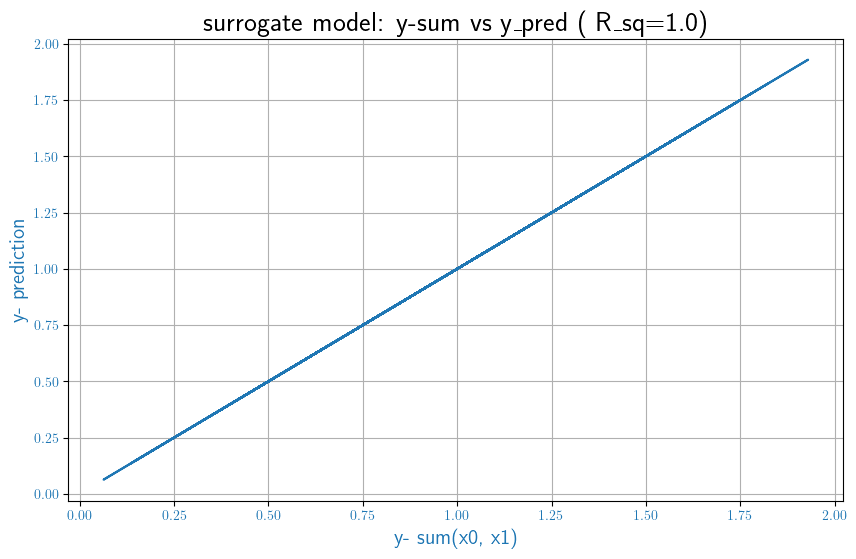

In [97]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('y- sum(x0, x1)', color=color, fontsize=15)
ax1.set_ylabel('y- prediction', color=color, fontsize=15)
ax1.plot(y, y_pred, color=color)
ax1.set_title(f"surrogate model: y-sum vs y_pred ({ R_sq=})", fontsize=20)
ax1.tick_params(axis='both', labelcolor=color)
ax1.grid()

In [98]:
# using actual variables SP_scale, DP_scale
X0 = np.hstack((data0['SP_scale'].values.reshape(-1, 1), data0['DP_scale'].values.reshape(-1, 1)))
y0 = data0['dcoef0'].values.reshape(-1, 1)
X00 = np.hstack((data0['Static_Pa'].values.reshape(-1, 1), data0['Differential_Pa'].values.reshape(-1, 1)))


In [99]:
linreg_baseline = LinearRegression().fit(X0, y0)

In [100]:
linreg_baseline.coef_

array([[0.40516383, 0.32629093]])

In [176]:
data0

,Static Pressure,LPM_Rota,temp_mcu,Static_Pa,SP_mV,DP_mV,Differential_Pa,Flow_lph,SB lpm,Accuracy,...,dc_lfs0,dc_lfs1,labfit_dcoef1_mapp,dcoef_dTree,dcoef_poly2D,flow0,flow_labfit0,flow_labfit1,flow_dTree,flow_poly2D
0,6.82,5,27.0,6953,32.74,1578.04,0.18,426,7.100000,1.420000,...,0.213051,0.385299,NaN,0.771175,0.905689,0.000041,0.000009,0.000017,0.000033,0.000039
1,6.82,5,27.0,6935,32.71,1578.04,0.18,426,7.100000,1.420000,...,0.213352,0.385297,NaN,0.771045,0.905546,0.000041,0.000009,0.000017,0.000033,0.000039
2,6.82,5,27.0,6898,32.66,1578.04,0.18,426,7.100000,1.420000,...,0.213974,0.385293,NaN,0.770779,0.905250,0.000041,0.000009,0.000017,0.000033,0.000039
3,20.10,5,27.0,20314,51.79,1573.93,0.23,482,8.033333,1.606667,...,0.130135,0.386744,NaN,0.766724,1.011179,0.000128,0.000007,0.000020,0.000039,0.000052
4,20.10,5,27.0,20204,51.63,1574.71,0.21,468,7.800000,1.560000,...,0.129028,0.386710,NaN,0.788938,1.010243,0.000125,0.000006,0.000019,0.000038,0.000049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,35.10,230,28.3,35787,73.85,848.45,181.37,13665,227.750000,0.990217,...,0.242931,0.381525,0.0,1.410110,1.367147,0.000259,0.000408,0.000641,0.002371,0.002299
241,35.10,230,28.3,35750,73.79,850.80,180.24,13622,227.033333,0.987101,...,0.242766,0.380496,0.0,1.414176,1.368649,0.000259,0.000407,0.000638,0.002370,0.002294
242,35.10,230,28.3,35732,73.77,850.01,180.62,13636,227.266667,0.988116,...,0.242847,0.380839,0.0,1.412537,1.367796,0.000259,0.000407,0.000639,0.002370,0.002295
243,43.07,230,28.3,43887,85.39,836.72,187.07,13878,231.300000,1.005652,...,0.238426,0.387615,0.0,1.471293,1.451147,0.000318,0.000407,0.000662,0.002512,0.002478


In [101]:
R0_sq=linreg_baseline.score(X0, y0)

In [102]:
y0_pred = linreg_baseline.predict(X0)


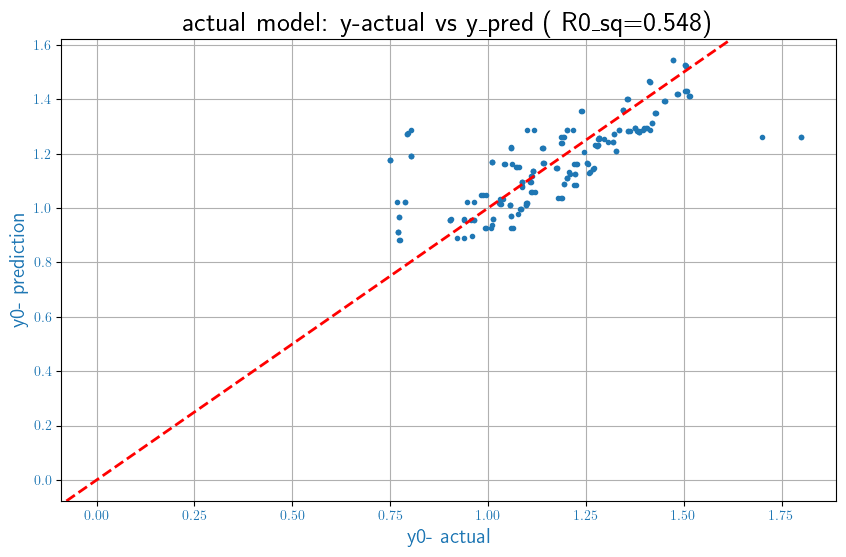

In [179]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('y0- actual', color=color, fontsize=15)
ax1.set_ylabel('y0- prediction', color=color, fontsize=15)
ax1.plot(y0, y0_pred, '.', color=color)
ax1.axline((0.00, 0.00), slope=1.0, linestyle='--', color='red', linewidth=2.0)
ax1.set_title(f"actual model: y-actual vs y_pred ({ R0_sq=:.3f})", fontsize=20)
ax1.tick_params(axis='both', labelcolor=color)
ax1.grid()

In [104]:
# try polyfit model for the data
# attempt a bayesian model fitting for the data

# 2D polyfit 

In [105]:
X_design = np.vstack((np.ones_like(data0['SP_scale']), data0['SP_scale'], data0['DP_scale'], data0['SP_scale']**2, data0['SP_scale']*data0['DP_scale'], data0['DP_scale']**2)).T

In [106]:
coef, r, rank, s= np.linalg.lstsq(X_design, y0)

/var/folders/f4/q6n418p95nb77wmf4l9zydddrkwtmh/T/ipykernel_2895/1270856328.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, r, rank, s= np.linalg.lstsq(X_design, y0)


In [107]:
y0_pred_ply = X_design @ coef

In [108]:
residual_ply = y0.reshape(-1, ) - y0_pred_ply.reshape(-1,) 
mse_ply = np.mean(residual_ply**2)
# what's the score of the polyfit model?
# the object doesn't have a score call...

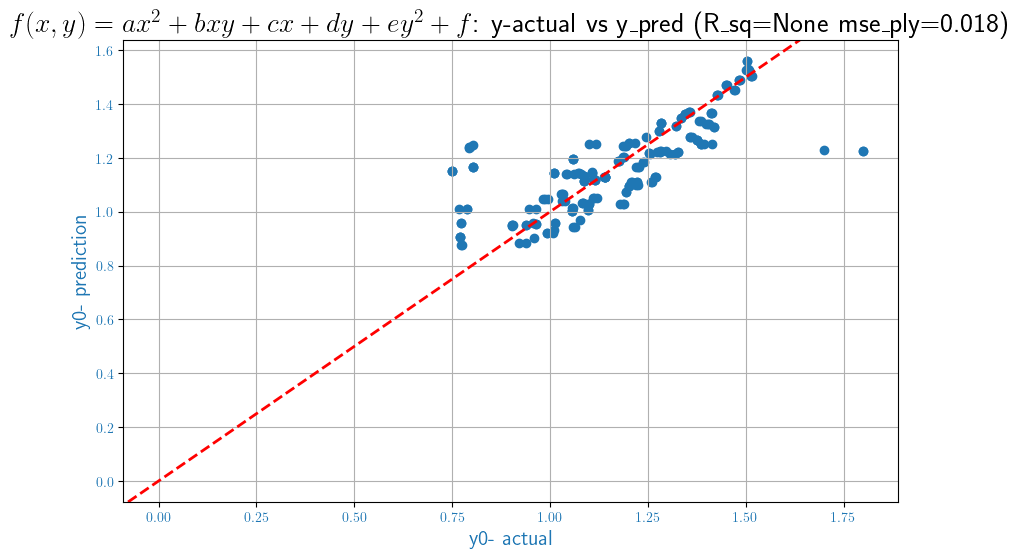

In [109]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('y0- actual', color=color, fontsize=15)
ax1.set_ylabel('y0- prediction', color=color, fontsize=15)
ax1.scatter(y0, y0_pred_ply, color=color)
ax1.axline((0.0, 0.0), slope=1, linestyle='--', color='red', linewidth=2.0)
ax1.set_title(f"$f(x, y) = a x^2 + b xy + cx+ dy+ ey^2 + f$: y-actual vs y_pred (R_sq={None} {mse_ply=:.3f})", fontsize=20)
ax1.tick_params(axis='both', labelcolor=color)
ax1.grid()

Text(0, 0.5, 'Residuals')

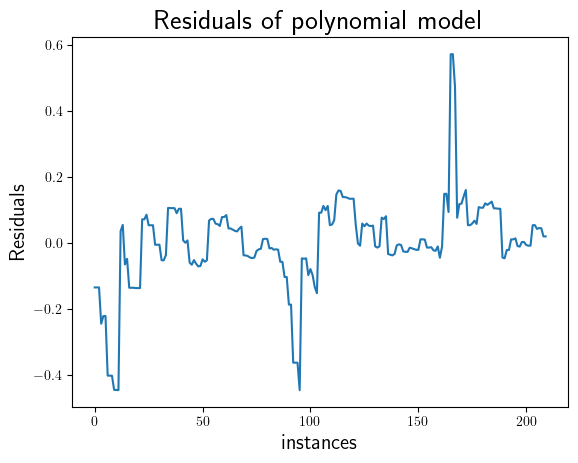

In [110]:
plt.plot(residual_ply)
plt.title("Residuals of polynomial model", fontsize=20)
plt.xlabel("instances", fontsize=15)
plt.ylabel("Residuals", fontsize=15)

In [111]:
# need to visualize

In [112]:
glinreg_gaussian = sm.GLM(y0, X0, family=sm.families.Gaussian(link=sm.families.links.Log()))

In [113]:
glinreg_gaussian.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  210
Model:                            GLM   Df Residuals:                      208
Model Family:                Gaussian   Df Model:                            1
Link Function:                    Log   Scale:                        0.022888
Method:                          IRLS   Log-Likelihood:                 99.621
Date:                Mon, 17 Feb 2025   Deviance:                       4.7608
Time:                        11:41:46   Pearson chi2:                     4.76
No. Iterations:                     6   Pseudo R-squ. (CS):             0.6212
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2383      0.015     15.715      0.000       0.209       0.268
x2             0.2134      0.026      8.339      0.000       0.163       0.264
==============================================================================
"""

In [114]:
glinreg_gaussian.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  210
Model:                            GLM   Df Residuals:                      208
Model Family:                Gaussian   Df Model:                            1
Link Function:                    Log   Scale:                        0.022888
Method:                          IRLS   Log-Likelihood:                 99.621
Date:                Mon, 17 Feb 2025   Deviance:                       4.7608
Time:                        11:41:46   Pearson chi2:                     4.76
No. Iterations:                     6   Pseudo R-squ. (CS):             0.6212
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2383      0.015     15.715      0.000       0.209       0.268
x2             0.2134      0.026      8.339      0.000       0.163       0.264
==============================================================================
"""

In [115]:
glinreg_gamma = sm.GLM(y0, X0, family=sm.families.Gamma())

/Users/duuta/anaconda3/envs/torchpp/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


In [116]:
glinreg_gamma.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  210
Model:                            GLM   Df Residuals:                      208
Model Family:                   Gamma   Df Model:                            1
Link Function:           InversePower   Scale:                         0.41005
Method:                          IRLS   Log-Likelihood:                -316.60
Date:                Mon, 17 Feb 2025   Deviance:                       147.60
Time:                        11:41:46   Pearson chi2:                     85.3
No. Iterations:                     8   Pseudo R-squ. (CS):             -4.109
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1886      0.065     18.195      0.000       1.061       1.317
x2             0.6645      0.103      6.449      0.000       0.463       0.866
==============================================================================
"""

# decisionTree Regressor

In [117]:
regressorD = DecisionTreeRegressor(random_state=0)
regressorD.fit(X, y)

DecisionTreeRegressor(random_state=0)

In [118]:
R_sq_surro_dt = regressorD.score(X,y.reshape(-1, ))
y_pred_surro_dt = regressorD.predict(X)

In [119]:
residuals_surro = y.reshape(-1, ) - y_pred_surro_dt
mse_surro = np.mean((y.reshape(-1,) - y_pred_surro_dt)**2)

Text(0, 0.5, 'Residuals')

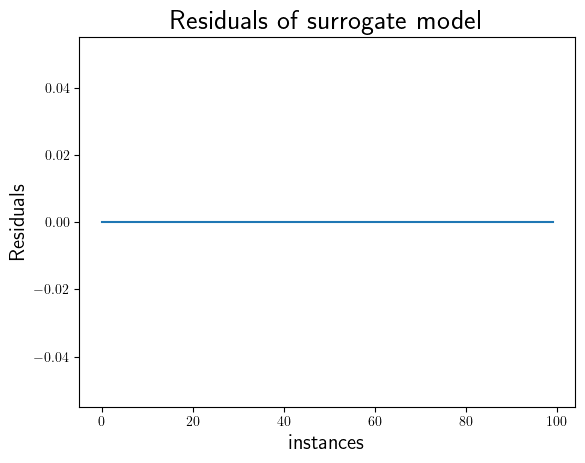

In [120]:
plt.plot(residuals_surro)
plt.title("Residuals of surrogate model", fontsize=20)
plt.xlabel("instances", fontsize=15)
plt.ylabel("Residuals", fontsize=15)

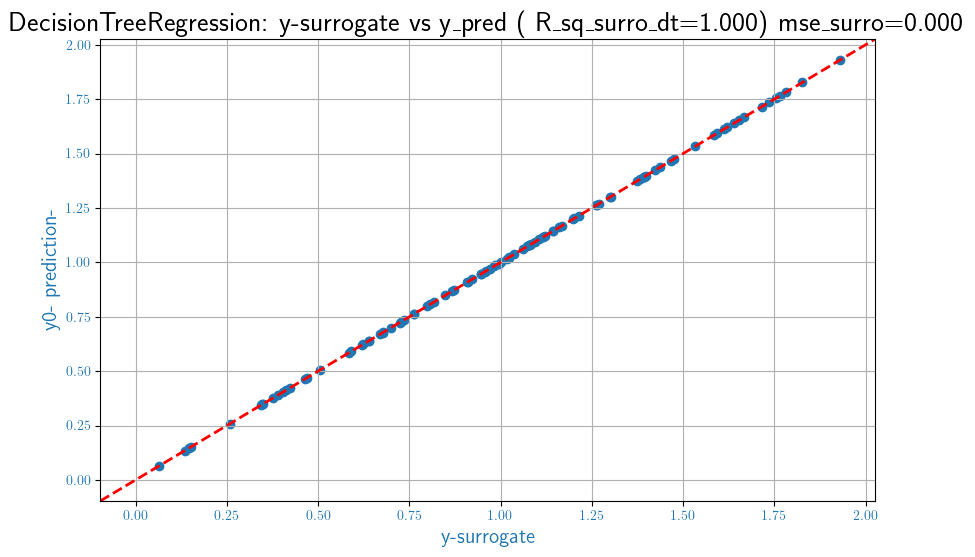

In [180]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('y-surrogate', color=color, fontsize=15)
ax1.set_ylabel('y0- prediction-', color=color, fontsize=15)
ax1.scatter(y, y_pred_surro_dt, color=color)
ax1.axline((0.00, 0.00), slope=1.0, linestyle='--', color='red', linewidth=2.0)
ax1.set_title(f"DecisionTreeRegression: y-surrogate vs y_pred ({ R_sq_surro_dt=:.3f}) {mse_surro=:.3f}", fontsize=20)
ax1.tick_params(axis='both', labelcolor=color)
ax1.grid()

y0.shape

In [122]:
y0.shape

(210, 1)

In [123]:
regressorD.fit(X0, y0)
R0_sq_dt = regressorD.score(X0, y0.reshape(-1, ))
y0_pred_dt = regressorD.predict(X0)

In [124]:
 residuals = y0.reshape(-1, ) - y0_pred_dt
 mse0 = np.mean(residuals**2)

In [125]:
def residual_plots(residuals, xlabel="instances", ylabel="Residuals", xfontsize=15, title="Residuals of actual model", Tfontsize=20, **kwargs):
    plt.plot(residuals, **kwargs)
    plt.title(title, fontsize=Tfontsize)
    plt.xlabel(xlabel, fontsize=xfontsize)
    plt.ylabel(ylabel, fontsize=yfontsize)

    return None

Text(0, 0.5, 'Residuals')

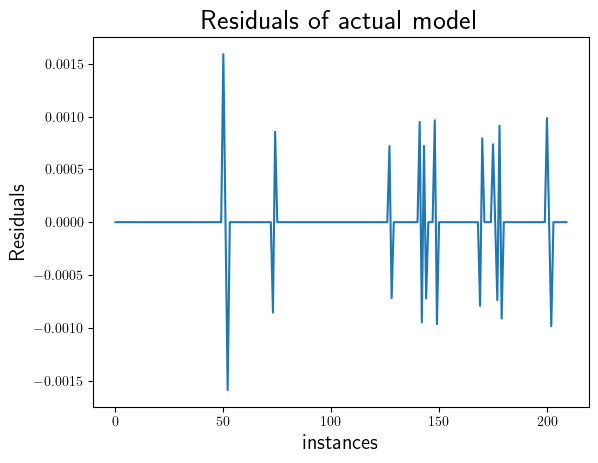

In [126]:
plt.plot(residuals)
plt.title("Residuals of actual model", fontsize=20)
plt.xlabel("instances", fontsize=15)
plt.ylabel("Residuals", fontsize=15)

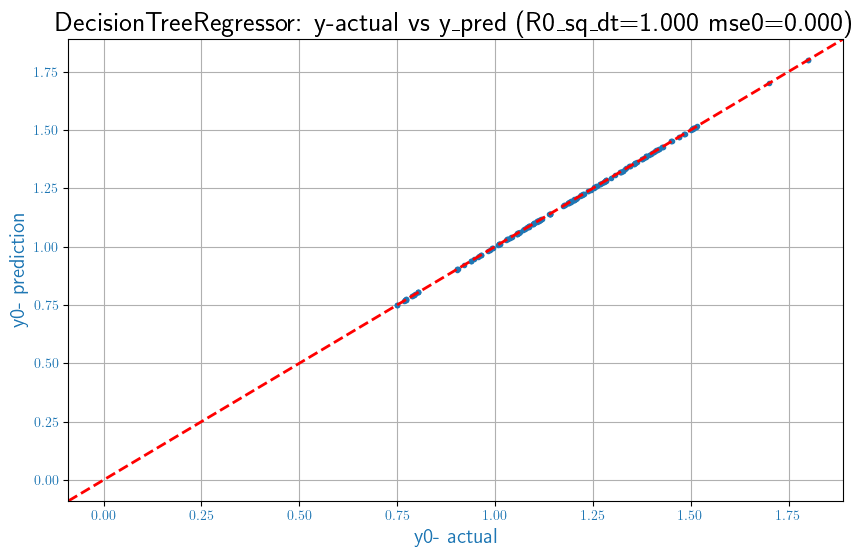

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('y0- actual', color=color, fontsize=15)
ax1.set_ylabel('y0- prediction', color=color, fontsize=15)
ax1.plot(y0, y0_pred_dt, '.', color=color)
ax1.axline((0.00, 0.00), slope=1, linestyle='--', color='red', linewidth=2.0)
ax1.set_title(f"DecisionTreeRegressor: y-actual vs y_pred ({R0_sq_dt=:.3f} {mse0=:.3f})", fontsize=20)
ax1.tick_params(axis='both', labelcolor=color)
ax1.grid()

In [128]:
# decision tree models seems to be really good, the mean square error (0.001) and the Score (0.99)) 
# compare the mean score errors of the lalbfit models vs the Decisions tree models
# make plot of the decision tree models

In [129]:
y0_labfit0 = data0['labfit_dcoef0'].values.reshape(-1, )
y0_labfit1 = data0['labfit_dcoef1'].values.reshape(-1, )

In [130]:
residuals00 = y0.reshape(-1, ) - y0_labfit0
residuals01= y0.reshape(-1,) - y0_labfit1 

mse00 = np.mean(residuals00**2)
mse01 = np.mean(residuals01**2)

/var/folders/f4/q6n418p95nb77wmf4l9zydddrkwtmh/T/ipykernel_2895/2748934094.py:5: RuntimeWarning: overflow encountered in square
  mse01 = np.mean(residuals01**2)


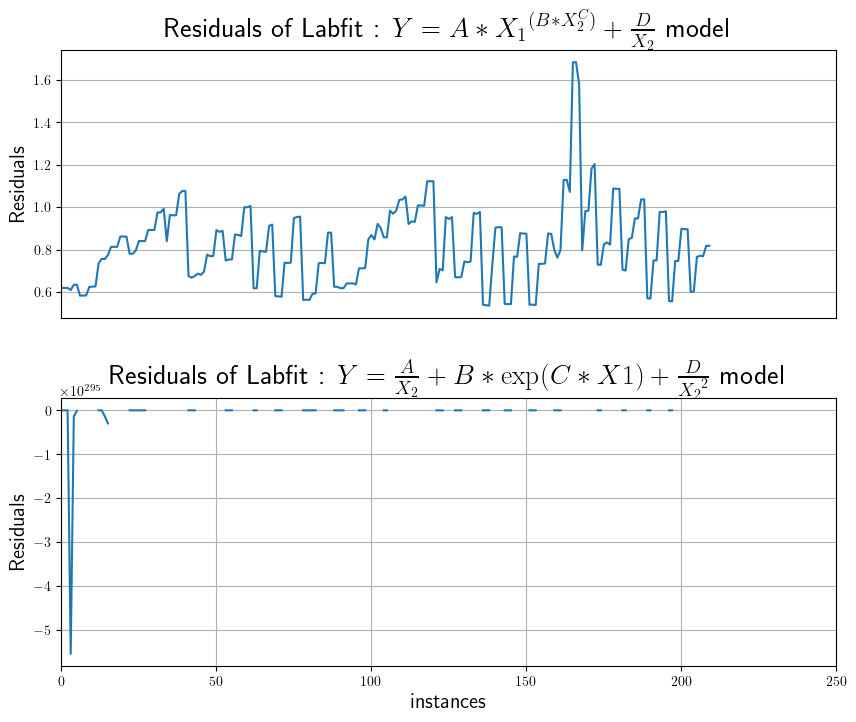

In [131]:
fig, ax00 = plt.subplots(2, 1, figsize=(10, 8))
ax00[0].plot(residuals00)
ax00[0].set_title(r"Residuals of Labfit : $Y=A*{X_{1}}^{(B*X_{2}^C)}+ \frac{D}{X_{2}}$  model", fontsize=20)
ax00[0].set_ylabel("Residuals", fontsize=15)
ax00[0].set_xlim([0, 250])
ax00[0].set_xticks([])
ax00[0].grid()
# adjust vertical space
plt.subplots_adjust(hspace=0.3)

ax00[1].plot(residuals01)
ax00[1].set_title(r"Residuals of Labfit : $Y=\frac{A}{X_{2}}+B*\exp(C*X1)+\frac{D}{{X_{2}}^2}$  model", fontsize=20)
ax00[1].set_xlabel("instances", fontsize=15)
ax00[1].set_ylabel("Residuals", fontsize=15)
ax00[1].set_xlim([0, 250])
ax00[1].grid()

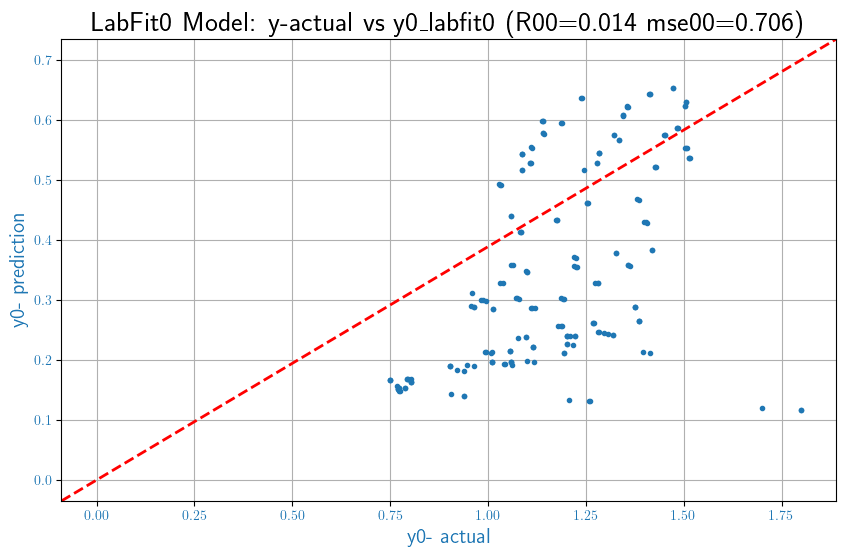

In [154]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('y0- actual', color=color, fontsize=15)
ax1.set_ylabel('y0- prediction', color=color, fontsize=15)
ax1.plot(y0, y0_labfit0, '.', color=color)
ax1.axline((0, 0), (1.80, 0.7), linestyle='--', color='red', linewidth=2.0)
ax1.set_title(f"LabFit0 Model: y-actual vs y0_labfit0 ({R00=:.3f} {mse00=:.3f})", fontsize=20)
ax1.tick_params(axis='both', labelcolor=color)
ax1.grid()

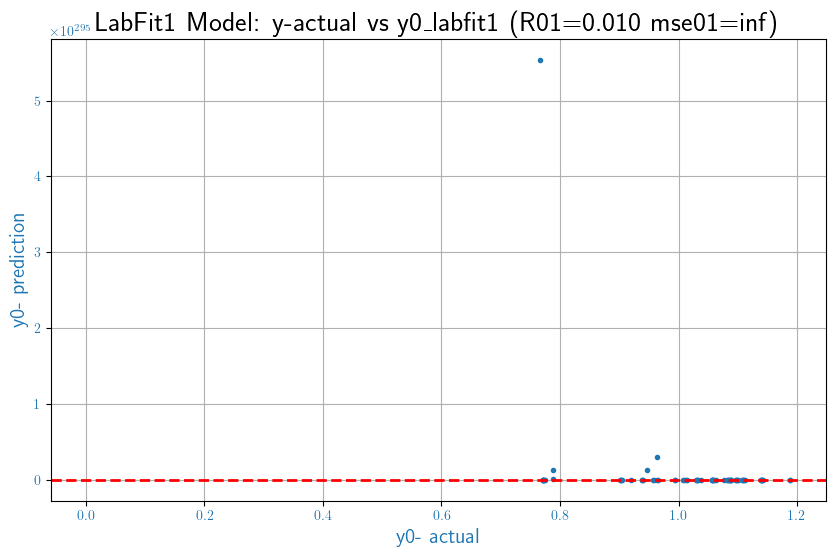

In [133]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('y0- actual', color=color, fontsize=15)
ax1.set_ylabel('y0- prediction', color=color, fontsize=15)
ax1.plot(y0, y0_labfit1, '.', color=color)
ax1.axline((0., 0.), slope=1, linestyle='--', color='red', linewidth=2.0)
ax1.set_title(f"LabFit1 Model: y-actual vs y0_labfit1 ({R01=:.3f} {mse01=:.3f})", fontsize=20)
ax1.tick_params(axis='both', labelcolor=color)
ax1.grid()

 # Curve_fit : attempting to recreate labfit model parameters 

In [134]:
# x0 = static_Pa , x1 = Differential Pa
#labfit0_func = lambda x0, x1, *p: p[0]*x1**(p[1]*x0**(p[2])) + p[3]/x0 
def labfit_func(X, p0, p1, p2, p3):
    x0, x1 = X[:, 0], X[:, 1]
    return p0*x1**(p1*x0**p2) + p3/x0 
    
def lm_model(X, p0, p1):
    x0, x1 = X[:,0], X[:, 1]
    return p0*x0 + p1*x1 
#initial_guess= [1, 1, 1, 1]

In [135]:
popt, pcov0=curve_fit(
    lm_model, 
    xdata=X, 
    ydata=y.flatten(),
    method='lm',
)

In [136]:
np.linalg.cond(pcov0)

inf

In [192]:
curve_fit(
    labfit_func, 
    xdata=X0, 
    ydata=y0.flatten(),
)

/var/folders/f4/q6n418p95nb77wmf4l9zydddrkwtmh/T/ipykernel_2895/3136598539.py:5: RuntimeWarning: divide by zero encountered in divide
  return p0*x1**(p1*x0**p2) + p3/x0
/Users/duuta/anaconda3/envs/torchpp/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([1., 1., 1., 1.]),
 array([[inf, inf, inf, inf],
        [inf, inf, inf, inf],
        [inf, inf, inf, inf],
        [inf, inf, inf, inf]]))

# make a plot for condition number of a matrix as function for perfectly fit regression model 

In [138]:

def make_plot(x_samples, y_condition):
    fig00, ax1 = plt.subplots(figure(10, 6))
    ax1.plot(x_samples, y_condition, 'r--', )
    ax1.set_title("Condition number vs Sample size", fontsize=20)
    ax1.set_xlabel("Sample Size")
    ax1.set_ylabel("Condition number")


def compute_condition_num(pcov):
    return np.linalg.cond(pcov)

def generate_data_samples(start, stop, size):
    return np.linspace(start, stop, size)
    
def get_pcov(func, xdata, y, **kwargs):
    _, pcov = curve_fit(func, xdata, y, **kwargs)
    return pcov

In [189]:
X.shape

(100, 2)

In [190]:
def datagen_wrapper(func, X0, y0, start0, stop0, start, stop, size):
    y = [] # init condition 
    X = []
    for i, num in enumerate(range(start, stop, size)):
        X.append(num)
        pcov = get_pcov(func, X0, y0)
        condNum =compute_condition_num(pcov) 
        y.append(condNum)
    
    return np.array(X), np.array(y)

        

In [197]:
curve_fit(lm_model, xdata=X, ydata=y.flatten())

(array([1., 1.]),
 array([[ 0., -0.],
        [-0.,  0.]]))

In [202]:
X_stab, y_stab = datagen_wrapper(lm_model, X, y.flatten(), 0.1, 0.5, 100, 500, 10)

# trying via meshgrid to check the labfit...


In [140]:
x_sp =data0['SP_scale'].values.reshape(-1, 1) 
x_dp =data0['DP_scale'].values.reshape(-1, 1)


SPv, DPv = np.meshgrid(data0['SP_scale'], data0['DP_scale'])
DCv, *_ = np.meshgrid(data0['dcoef0'])


X_sp, X_dp = np.meshgrid(x_sp, x_dp)
x_data = np.vstack([X_sp.ravel(), X_dp.ravel()])

# compute the meshgrid for the data 
# use that to compute the fuction 
# find parameters for the model 
# how to choose parameters to initialize the model... 
# then verify if curve_fit to generate the model the...

# Gaussian Process regression 


# differential optimization

In [141]:
# optimize the labfit_func see if you get the parameters from  labfit tool 
# attempt today...
#  

In [142]:
# plot x0, x1, dcoef (3D)
# compare baseline regression with baseline of... 
# see if curve fit will generate the parameter values of labfit...
# results with curve_fit is not very stable
# the pcov is ill-conditioned, 
# attempt setting a region for the optimization
# if the fit is perfect the pcov matrix is ill-condition, appears ill conditioned...,
# is not as a result of collinearity issues, 
# followed for the results...
# how to cast R-sq in terms of reduced chi-squared. 

In [143]:
# the structure in CD variable in the data is inherited from the models computation
# or is inherited from some other source?
# DC appears to be some regularization of the model values
# the model values are negative
# why do we have values of 12 in the data? I thought the max was 1 in DC data?
# what are the reasonable values of Discharge coefficient (min, max)

In [144]:
data0['dcoef_dTree'] = y0_pred_dt 
data0['dcoef_poly2D'] = y0_pred_ply.reshape(-1, ) 

In [145]:
# convert dc to flow 
# plot flow
# integrate flow for various flows
# and compare the performance the in terms of the consumptions
# 
# flow formulae
# discharge_coefficient * A2 * sqrt(2* Differential_Pa )/ (ro*(1 - (A2/A1)^2))

data0['flow0'] = data0.apply(lambda row: flow_amounts(row.dcoef, row.DP_scale), axis=1)
data0['flow_labfit0'] = data0.apply(lambda row: flow_amounts(row.dc_lfs0, row.DP_scale), axis=1)
data0['flow_labfit1'] = data0.apply(lambda row: flow_amounts(row.dc_lfs1, row.DP_scale), axis=1)
data0['flow_dTree'] = data0.apply(lambda row: flow_amounts(row.dcoef_dTree, row.DP_scale), axis=1)
data0['flow_poly2D'] = data0.apply(lambda row: flow_amounts(row.dcoef_poly2D, row.DP_scale), axis=1)

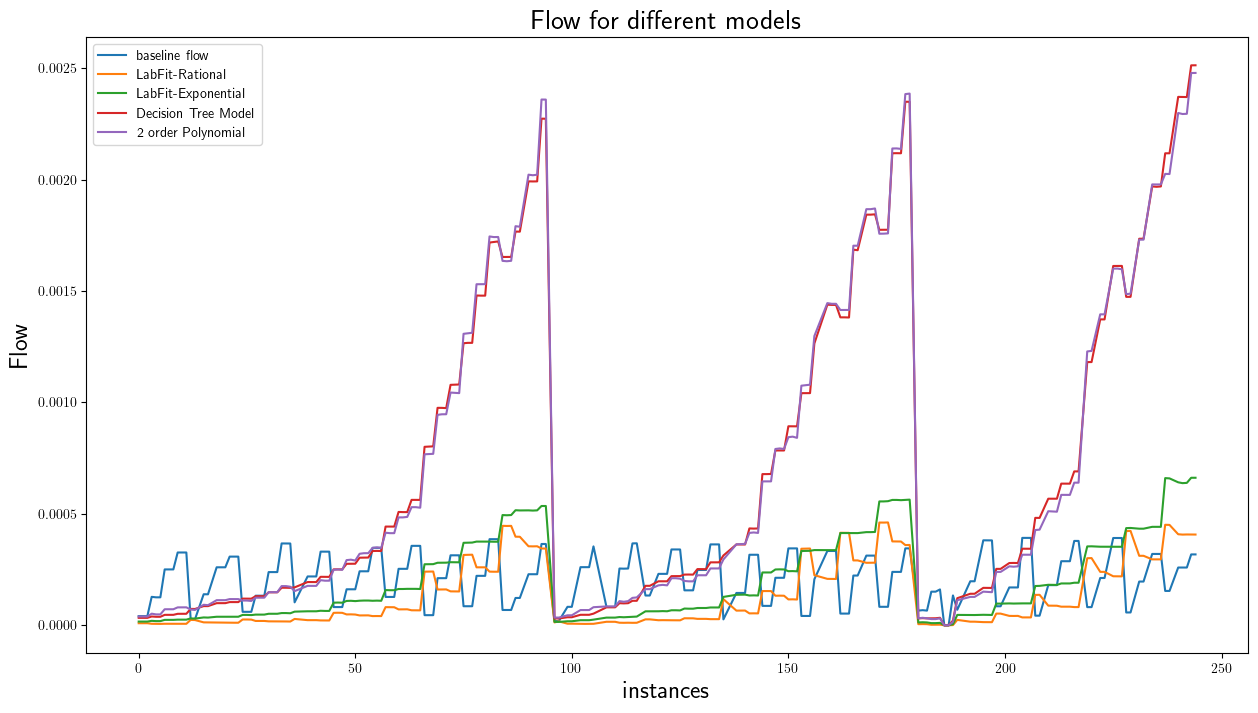

In [182]:
plt.subplots(figsize=(15, 8))
plt.plot(data0.flow0, label='baseline flow')
plt.xlabel("instances", fontsize=18)
plt.ylabel("Flow", fontsize=18)
plt.plot(data0.flow_labfit0, label='LabFit-Rational') 
plt.plot(data0.flow_labfit1, label='LabFit-Exponential')
plt.plot(data0.flow_dTree, label='Decision Tree Model')
plt.plot(data0.flow_poly2D, label='2 order Polynomial')
plt.title("Flow for different models", fontsize=20)
plt.legend()

In [ ]:
# insert formulae for next time...

In [ ]:
# Integrate to the flow functions...
# why doesn't he care about the coefficient being close to one...
# 

flow0_baseline = trapz(data0.flow0, dx=2)
flow0_labfit0 = trapz(data0.flow_labfit0, dx=2) 
flow0_labfit1= trapz(data0.flow_labfit1, dx=2)
flow0_dTree = trapz(data0.flow_dTree, dx=2)
flow0_poly = trapz(data0.flow_poly2D, dx=2)

In [ ]:
# Test models for new data sets... 
# use models to predict cd values for new datasets 
# compute mse metric and visualize the predictions
# 

In [ ]:
def transfrom_data(test_MAC):
    test_MAC['LPM_rota_norm'] = test_MAC.apply(LPM_rota_normalization, axis=1)
    test_MAC['SB_lpm'] = test_MAC.apply(SB_lpm, axis=1)
    test_MAC['dcoef0'] = test_MAC['LPM_rota_norm']/test_MAC['SB_lpm']

    # Min-Max scaling  
    test_MAC['SP_scale'] =  (test_MAC.Static_Pa - min(test_MAC.Static_Pa))/ (max(test_MAC.Static_Pa) - min(test_MAC.Static_Pa) ) 
    test_MAC['DP_scale'] =  (test_MAC.Differential_Pa - min(test_MAC.Differential_Pa))/ (max(test_MAC.Differential_Pa) - min(test_MAC.Differential_Pa)) 
    return test_MAC 

def get_X(data0):
    X0 = np.hstack((data0['SP_scale'].values.reshape(-1, 1), data0['DP_scale'].values.reshape(-1, 1)))
    return X0

def get_X_design(data0):
    X_design = np.vstack((np.ones_like(data0['SP_scale']), data0['SP_scale'], data0['DP_scale'], data0['SP_scale']**2, data0['SP_scale']*data0['DP_scale'], data0['DP_scale']**2)).T
    return X_design

In [228]:
def visual_fit(y0, y0_pred, R00, mse00):

    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel('y0- actual', color=color, fontsize=15)
    ax1.set_ylabel('y0- prediction', color=color, fontsize=15)
    ax1.plot(y0, y0_pred, '.', color=color)
    ax1.axline((0, 0), slope=1.0, linestyle='--', color='red', linewidth=2.0)
    ax1.set_title(f" Model: y-actual vs y0_pred ({R00=:.3f} {mse00=:.3f})", fontsize=20)
    ax1.tick_params(axis='both', labelcolor=color)
    ax1.grid()

In [221]:
test_MAC.columns

Index(['Static Pressure', 'LPM_Rota', 'periph_ch1', 'temp_mcu', 'Static_Pa',
       'SP_mV', 'DP_mV', 'Differential_Pa', 'Flow_lph', 'dcoef', 'SB lpm',
       'Accuracy', 'Error', 'LPM_rota_norm', 'SB_lpm', 'dcoef0', 'SP_scale',
       'DP_scale'],
      dtype='object')

In [214]:
#  some transformations a
test_MAC['LPM_rota_norm'] = test_MAC.apply(LPM_rota_normalization, axis=1)
test_MAC['SB_lpm'] = test_MAC.apply(SB_lpm, axis=1)
test_MAC['dcoef0'] = test_MAC['LPM_rota_norm']/test_MAC['SB_lpm']


# Min-Max scaling  
test_MAC['SP_scale'] =  (test_MAC.Static_Pa - min(test_MAC.Static_Pa))/ (max(test_MAC.Static_Pa) - min(test_MAC.Static_Pa) ) 
test_MAC['DP_scale'] =  (test_MAC.Differential_Pa - min(test_MAC.Differential_Pa))/ (max(test_MAC.Differential_Pa) - min(test_MAC.Differential_Pa)) 


# predicting the Discharge coefficient using DecisionTree test data... 

In [217]:
X_testMAC = np.hstack([test_MAC['SP_scale'].values.reshape(-1, 1), test_MAC['DP_scale'].values.reshape(-1, 1)])

In [225]:
ypred_testMAC = regressorD.predict(X_testMAC)

In [ ]:
test_ma.shap

(90, 37)

In [ ]:
residual_MAC = ypred_testMAC - test_MAC['dcoef']
mse_MAC =  np.mean(residual_MAC**2)

In [231]:
mse_MAC

0.07337744392660608

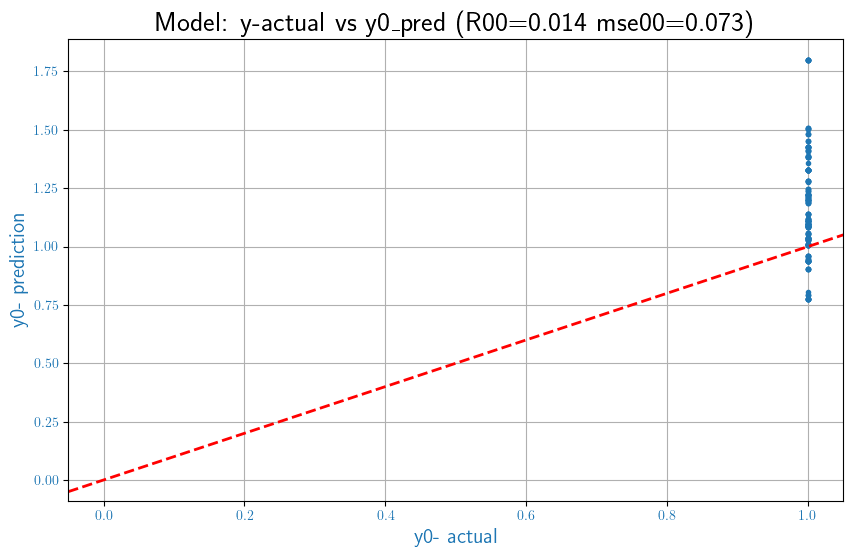

In [229]:
visual_fit(test_MAC['dcoef'], ypred_testMAC, R00, mse_MAC)

# predicting the Discharge coefficient using poly2D test data... 